In [0]:
import seaborn           as sns
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import tensorflow        as tf
from   tensorflow                import keras
from   tensorflow.keras          import layers
from   sklearn.model_selection   import train_test_split
from   sklearn.model_selection   import StratifiedKFold
from   sklearn.feature_selection import SelectKBest
from   sklearn.feature_selection import chi2
from   keras.models              import Sequential
from   keras.layers              import Dense, Dropout
from   keras.optimizers          import SGD
from   keras.callbacks           import EarlyStopping

In [2]:
# Upload dataset
from google.colab import files
uploaded = files.upload()

Saving hour.csv to hour.csv


In [0]:
# Load hours dataset
path = "./hour.csv"
dataset = pd.read_csv(path)

In [4]:
for i in dataset.columns.values:
  print(i, dataset[i].dtype)

instant int64
dteday object
season int64
yr int64
mnth int64
hr int64
holiday int64
weekday int64
workingday int64
weathersit int64
temp float64
atemp float64
hum float64
windspeed float64
casual int64
registered int64
cnt int64


In [5]:
dataset.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [0]:
def generate_dummies(df, dummy_column):
    dummies = pd.get_dummies(df[dummy_column], prefix=dummy_column)
    df = pd.concat([df, dummies], axis=1)
    return df

X = pd.DataFrame.copy(dataset)
dummy_columns = ["season",     # season (1:springer, 2:summer, 3:fall, 4:winter)
                 "mnth",        # month ( 1 to 12)
                 "hr",          # hour (0 to 23)
                 "weekday",     # weekday : day of the week
                 "weathersit"   # weathersit : 
                                 # - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
                                 # - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
                                 # - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
                                 # - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
                ]
for dummy_column in dummy_columns:
    X = generate_dummies(X, dummy_column)

In [0]:
for dummy_column in dummy_columns:
  del X[dummy_column]

In [0]:
del X["yr"]
del X["hum"]
del X["instant"]
del X["dteday"]

y = X["cnt"]

del X["cnt"]
del X["registered"]
del X["casual"]

In [9]:
X.head()
print(X.columns.values)

['holiday' 'workingday' 'temp' 'atemp' 'windspeed' 'season_1' 'season_2'
 'season_3' 'season_4' 'mnth_1' 'mnth_2' 'mnth_3' 'mnth_4' 'mnth_5'
 'mnth_6' 'mnth_7' 'mnth_8' 'mnth_9' 'mnth_10' 'mnth_11' 'mnth_12' 'hr_0'
 'hr_1' 'hr_2' 'hr_3' 'hr_4' 'hr_5' 'hr_6' 'hr_7' 'hr_8' 'hr_9' 'hr_10'
 'hr_11' 'hr_12' 'hr_13' 'hr_14' 'hr_15' 'hr_16' 'hr_17' 'hr_18' 'hr_19'
 'hr_20' 'hr_21' 'hr_22' 'hr_23' 'weekday_0' 'weekday_1' 'weekday_2'
 'weekday_3' 'weekday_4' 'weekday_5' 'weekday_6' 'weathersit_1'
 'weathersit_2' 'weathersit_3' 'weathersit_4']


In [73]:
all_days = len(X) // 24
print("Total observations", len(X))
print("Total number of days", all_days)
days_for_training = int(all_days * 0.7 * 24)
print(days_for_training)

X_train = X[0:days_for_training]
X_test = X[days_for_training:]
print(len(X_train), len(X_test))

y_train = y[0:days_for_training]
y_test= y[days_for_training:]
print(len(y_train), len(y_test))

Total observations 17379
Total number of days 724
12163
12163 5216
12163 5216


In [74]:
print("Observations for training", len(X_train))
print("Observations for testing", len(X_test))
print("Some target values", y.head())

Observations for training 12163
Observations for testing 5216
Some target values 0    16
1    40
2    32
3    13
4     1
Name: cnt, dtype: int64


In [75]:
print("Sum of X_train columns: ", len(X_train.columns.values))
print("Columns of X_train: \n", X_train.columns.values)

Sum of X_train columns:  56
Columns of X_train: 
 ['holiday' 'workingday' 'temp' 'atemp' 'windspeed' 'season_1' 'season_2'
 'season_3' 'season_4' 'mnth_1' 'mnth_2' 'mnth_3' 'mnth_4' 'mnth_5'
 'mnth_6' 'mnth_7' 'mnth_8' 'mnth_9' 'mnth_10' 'mnth_11' 'mnth_12' 'hr_0'
 'hr_1' 'hr_2' 'hr_3' 'hr_4' 'hr_5' 'hr_6' 'hr_7' 'hr_8' 'hr_9' 'hr_10'
 'hr_11' 'hr_12' 'hr_13' 'hr_14' 'hr_15' 'hr_16' 'hr_17' 'hr_18' 'hr_19'
 'hr_20' 'hr_21' 'hr_22' 'hr_23' 'weekday_0' 'weekday_1' 'weekday_2'
 'weekday_3' 'weekday_4' 'weekday_5' 'weekday_6' 'weathersit_1'
 'weathersit_2' 'weathersit_3' 'weathersit_4']


In [0]:
y_normalized = (y - y.min()) / (y.max() - y.min())
y_normalized.head()

y_train = y[0:days_for_training]
y_test = y[days_for_training:]
y_train_normalized = y_normalized[0:days_for_training]
y_test_normalized = y_normalized[days_for_training:]

In [225]:
features = X.shape[1]

model = Sequential()
model.add(Dense(58, input_shape=(features,), activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(58, input_shape=(features,), activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='linear'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_85 (Dense)             (None, 58)                3306      
_________________________________________________________________
dropout_42 (Dropout)         (None, 58)                0         
_________________________________________________________________
dense_86 (Dense)             (None, 58)                3422      
_________________________________________________________________
dropout_43 (Dropout)         (None, 58)                0         
_________________________________________________________________
dense_87 (Dense)             (None, 1)                 59        
Total params: 6,787
Trainable params: 6,787
Non-trainable params: 0
_________________________________________________________________


In [0]:
#compile model using mse as a measure of model performance
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd, 
              loss="mean_squared_error")

In [227]:
#set early stopping monitor so the model stops training when it won't improve anymore
early_stopping_monitor = EarlyStopping(patience=10)
results = model.fit(X.sample(frac=1),
                    y_normalized.sample(frac=1),
                    validation_split = 0.2,
                    #validation_data = (X_test, y_test_normalized),
                    epochs = 50,
                    batch_size = 28,
                    callbacks = [early_stopping_monitor],
                    verbose = 1) 

Train on 13903 samples, validate on 3476 samples
Epoch 1/50
13903/13903 [==============================] - 3s 191us/step - loss: 0.0528 - val_loss: 0.0378
Epoch 2/50
13903/13903 [==============================] - 1s 59us/step - loss: 0.0414 - val_loss: 0.0362
Epoch 3/50
13903/13903 [==============================] - 1s 59us/step - loss: 0.0391 - val_loss: 0.0357
Epoch 4/50
13903/13903 [==============================] - 1s 59us/step - loss: 0.0381 - val_loss: 0.0353
Epoch 5/50
13903/13903 [==============================] - 1s 60us/step - loss: 0.0374 - val_loss: 0.0352
Epoch 6/50
13903/13903 [==============================] - 1s 59us/step - loss: 0.0366 - val_loss: 0.0350
Epoch 7/50
13903/13903 [==============================] - 1s 59us/step - loss: 0.0363 - val_loss: 0.0349
Epoch 8/50
13903/13903 [==============================] - 1s 58us/step - loss: 0.0361 - val_loss: 0.0347
Epoch 9/50
13903/13903 [==============================] - 1s 59us/step - loss: 0.0360 - val_loss: 0.0347
Epoch

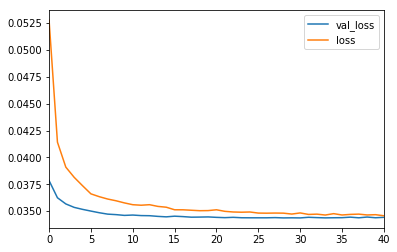

In [228]:
results.history
pd.DataFrame.from_dict(results.history).plot()